In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="white")

import requests
from bs4 import BeautifulSoup
from newspaper import Article 
from utils import *

In [2]:
FILEPATH = 'data/OnlineNewsPopularity.csv'
data = pd.read_csv(FILEPATH)

data['index'] = range(len(data))
data = data.set_index('index')
print(data.shape)

(39644, 61)


In [3]:
data.iloc[0]

url                              http://mashable.com/2013/01/07/amazon-instant-...
 timedelta                                                                     731
 n_tokens_title                                                                 12
 n_tokens_content                                                              219
 n_unique_tokens                                                          0.663594
                                                       ...                        
 title_subjectivity                                                            0.5
 title_sentiment_polarity                                                  -0.1875
 abs_title_subjectivity                                                          0
 abs_title_sentiment_polarity                                               0.1875
 shares                                                                        593
Name: 0, Length: 61, dtype: object

In [4]:
col = data.columns
col

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

### Selecting important features

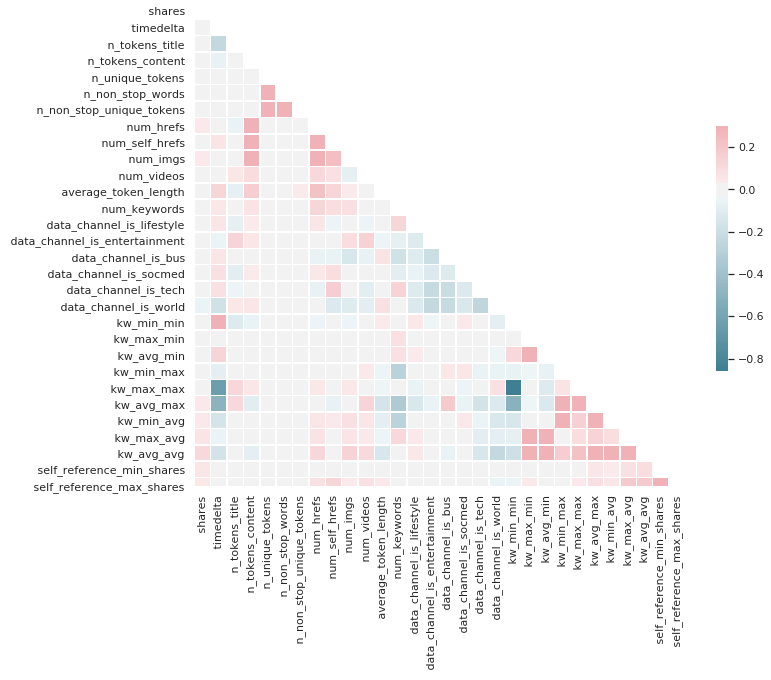

In [5]:
first_half = data[col[:30]]

first_half = pd.concat([data[' shares'], first_half], axis=1)

corr = first_half.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In the first 30 features, num_hrefs, num_imgs, data_channel_is_world, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference are correlated to shares.

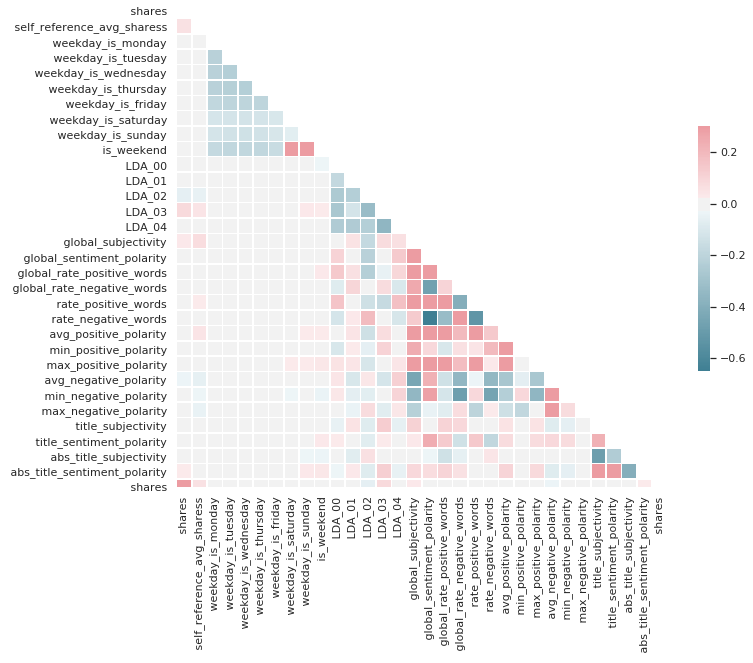

In [6]:
sec_half = data[col[30:]]

sec_half = pd.concat([data[' shares'], sec_half], axis=1)

corr = sec_half.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In later half of features, self_reference, LDA_02, LDA_03, global_subjectivity, avg_negetive_polarity are correlated to shares.

In [7]:
features = data[col].corr()[' shares'][:]
# features = np.array(features)
print("Positively correlated features: \n")
print(features[features>0.02]) 
print("\n\n Negatively correlated features: \n")
print(features[features< -0.02]) 

Positively correlated features: 

 num_hrefs                       0.045404
 num_imgs                        0.039388
 num_videos                      0.023936
 num_keywords                    0.021818
 kw_max_min                      0.030114
 kw_avg_min                      0.030406
 kw_avg_max                      0.044686
 kw_min_avg                      0.039551
 kw_max_avg                      0.064306
 kw_avg_avg                      0.110413
 self_reference_min_shares       0.055958
 self_reference_max_shares       0.047115
 self_reference_avg_sharess      0.057789
 LDA_03                          0.083771
 global_subjectivity             0.031604
 title_subjectivity              0.021967
 abs_title_sentiment_polarity    0.027135
 shares                          1.000000
Name:  shares, dtype: float64


 Negatively correlated features: 

 average_token_length    -0.022007
 data_channel_is_world   -0.049497
 LDA_02                  -0.059163
 avg_negative_polarity   -0.032029
Nam

In [8]:
data[' shares'].describe()

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name:  shares, dtype: float64

Rather than predicting the actual number of shares, we may predict, whether the number of shares is high or low.<br/>
<br/>
(shares < 950)                    : low <br/>
(shares > 950  and shares < 1400) : intermediate <br/>
(shares > 1400 and shares < 2800) : high <br/>
(shares > 2800 and shares < 10000) : very high <br/>
(shares > 10000)                  : vv high 

In [9]:
cats = []
for i in range(len(data[' shares'])):
    if data[' shares'][i] < 950:
        cats.append(0)
    elif data[' shares'][i] > 950 and data[' shares'][i] < 1400:
        cats.append(1)
    elif data[' shares'][i] > 1400 and data[' shares'][i] < 2800:
        cats.append(2)
    elif data[' shares'][i] > 2800 and data[' shares'][i] < 10000:
        cats.append(3)
    else:
        cats.append(4)

In [10]:
cats = pd.DataFrame(cats, columns=['cats'])
data1 = pd.concat([data, cats], axis=1)
data1

url   timedelta  \
0      http://mashable.com/2013/01/07/amazon-instant-...       731.0   
1      http://mashable.com/2013/01/07/ap-samsung-spon...       731.0   
2      http://mashable.com/2013/01/07/apple-40-billio...       731.0   
3      http://mashable.com/2013/01/07/astronaut-notre...       731.0   
4       http://mashable.com/2013/01/07/att-u-verse-apps/       731.0   
...                                                  ...         ...   
39639  http://mashable.com/2014/12/27/samsung-app-aut...         8.0   
39640  http://mashable.com/2014/12/27/seth-rogen-jame...         8.0   
39641  http://mashable.com/2014/12/27/son-pays-off-mo...         8.0   
39642     http://mashable.com/2014/12/27/ukraine-blasts/         8.0   
39643  http://mashable.com/2014/12/27/youtube-channel...         8.0   

        n_tokens_title   n_tokens_content   n_unique_tokens  \
0                 12.0              219.0          0.663594   
1                  9.0              255.0          0.604743   
2                  9.0              211.0          0.575130   
3                  9.0              531.0          0.503788   
4                 13.0             1072.0          0.415646   
...                ...                ...               ...   
39639             11.0              346.0          0.529052   
39640             12.0              328.0          0.696296   
39641             10.0              442.0          0.516355   
39642              6.0              682.0          0.539493   
39643             10.0              157.0          0.701987   

        n_non_stop_words   n_non_stop_unique_tokens   num_hrefs  \
0                    1.0                   0.815385         4.0   
1                    1.0                   0.791946         3.0   
2                    1.0                   0.663866         3.0   
3                    1.0                   0.665635         9.0   
4                    1.0                   0.540890        19.0   
...                  ...                        ...         ...   
39639                1.0                   0.684783         9.0   
39640                1.0                   0.885057         9.0   
39641                1.0                   0.644128        24.0   
39642                1.0                   0.692661        10.0   
39643                1.0                   0.846154         1.0   

        num_self_hrefs   num_imgs  ...   max_positive_polarity  \
0                  2.0        1.0  ...                    0.70   
1                  1.0        1.0  ...                    0.70   
2                  1.0        1.0  ...                    1.00   
3                  0.0        1.0  ...                    0.80   
4                 19.0       20.0  ...                    1.00   
...                ...        ...  ...                     ...   
39639              7.0        1.0  ...                    0.75   
39640              7.0        3.0  ...                    0.70   
39641              1.0       12.0  ...                    0.50   
39642              1.0        1.0  ...                    0.50   
39643              1.0        0.0  ...                    0.50   

        avg_negative_polarity   min_negative_polarity   max_negative_polarity  \
0                   -0.350000                  -0.600               -0.200000   
1                   -0.118750                  -0.125               -0.100000   
2                   -0.466667                  -0.800               -0.133333   
3                   -0.369697                  -0.600               -0.166667   
4                   -0.220192                  -0.500               -0.050000   
...                       ...                     ...                     ...   
39639               -0.260000                  -0.500               -0.125000   
39640               -0.211111                  -0.400               -0.100000   
39641               -0.356439                  -0.800               -0.166667   
39642               -0.

Fitting a baseline NN, with all features included.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def clean_cols(data):
    """Clean the column names by stripping and lowercase."""
    clean_col_map = {x: x.lower().strip() for x in list(data)}
    return data.rename(columns=clean_col_map)

def TrainTestSplit(X, Y, R=0, test_size=0.2):
    """Easy Train Test Split call."""
    return train_test_split(X, Y, test_size=test_size, random_state=R)

In [12]:
# Importing standardscalar module  
from sklearn.preprocessing import StandardScaler 
scalar = StandardScaler() 
  
# fitting training data
scalar.fit(data) 
scaled_data = scalar.transform(data) 
  
# Importing PCA 
from sklearn.decomposition import PCA 
  
# Let's say, components = 2 
pca = PCA(n_components = 5) 
pca.fit(scaled_data) 
x_pca = pca.transform(scaled_data) 
  
x_pca = pd.DataFrame(x_pca)
x_pca.head()

ValueError: could not convert string to float: 'http://mashable.com/2013/01/07/amazon-instant-video-browser/'

In [13]:
full_data = clean_cols(data1)
train_set, test_set = train_test_split(full_data, test_size=0.20, random_state=42)

x_train = train_set.drop(['url','shares', 'cats'], axis=1)##, 'timedelta', 'lda_00','lda_01','lda_02','lda_03','lda_04','num_self_hrefs', 'kw_min_min', 'kw_max_min', 'kw_avg_min','kw_min_max','kw_max_max','kw_avg_max','kw_min_avg','kw_max_avg','kw_avg_avg','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','rate_positive_words','rate_negative_words','abs_title_subjectivity','abs_title_sentiment_polarity'], axis=1)
y_train = train_set['cats']

x_test = test_set.drop(['url','shares', 'cats'], axis=1)##, 'timedelta', 'lda_00','lda_01','lda_02','lda_03','lda_04','num_self_hrefs', 'kw_min_min', 'kw_max_min', 'kw_avg_min','kw_min_max','kw_max_max','kw_avg_max','kw_min_avg','kw_max_avg','kw_avg_avg','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','rate_positive_words','rate_negative_words','abs_title_subjectivity','abs_title_sentiment_polarity'], axis=1)
y_test = test_set['cats']

print(x_train.shape)
x_train.head()

(31715, 59)


timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
19837      338.0            15.0             628.0         0.509709   
904        715.0            11.0             409.0         0.519608   
23876      262.0             7.0             345.0         0.609329   
22966      279.0            11.0             217.0         0.580189   
4705       647.0            13.0             123.0         0.739837   

       n_non_stop_words  n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  \
19837               1.0                  0.645084       14.0             1.0   
904                 1.0                  0.657480        2.0             0.0   
23876               1.0                  0.783920        5.0             2.0   
22966               1.0                  0.775000        8.0             2.0   
4705                1.0                  0.887324        3.0             0.0   

       num_imgs  num_videos  ...  avg_positive_polarity  \
19837       1.0         0.0  ...               0.275971   
904         1.0         0.0  ...               0.295343   
23876       1.0         0.0  ...               0.428715   
22966       3.0         0.0  ...               0.325667   
4705        1.0         0.0  ...               0.444524   

       min_positive_polarity  max_positive_polarity  avg_negative_polarity  \
19837               0.033333                    0.8              -0.259184   
904                 0.136364                    0.5              -0.133333   
23876               0.062500                    0.6              -0.282639   
22966               0.033333                    0.5              -0.098214   
4705                0.200000                    1.0              -0.550000   

       min_negative_polarity  max_negative_polarity  title_subjectivity  \
19837              -0.500000              -0.100000            0.458333   
904                -0.166667              -0.100000            0.000000   
23876              -0.800000              -0.050000            0.000000   
22966              -0.125000              -0.071429            0.550000   
4705               -1.000000              -0.100000            0.000000   

       title_sentiment_polarity  abs_title_subjectivity  \
19837                  0.333333                0.041667   
904                    0.000000                0.500000   
23876                  0.000000                0.500000   
22966                  0.200000                0.050000   
4705                   0.000000                0.500000   

       abs_title_sentiment_polarity  
19837                      0.333333  
904                        0.000000  
23876                      0.000000  
22966                      0.200000  
4705                       0.000000  

[5 rows x 59 columns]

In [14]:
# Convert to One hot encoding
from keras.utils import to_categorical

y_train_enc = to_categorical(y_train)
print(y_train_enc[:5])

y_test_enc = to_categorical(y_test)
print(y_test_enc[:5])

inverted = np.argmax(y_train_enc[0])
print(inverted)

Using TensorFlow backend.


[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
4


In [15]:
g1 = sns.countplot(y_test)

In [16]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier

from time import time
from sklearn.metrics import jaccard_score, accuracy_score, fbeta_score, roc_curve, auc, roc_auc_score

In [17]:
X_train_ADA, X_test_ADA, y_train_ADA, y_test_ADA = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)

X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)

print("Training set has {} samples.".format(X_train_ADA.shape[0]))
print("Testing set has {} samples.".format(X_test_ADA.shape[0]))

samples_10 = int(X_train_ADA.shape[0]*0.1)
samples_100 = X_train_ADA.shape[0]

clf_A = AdaBoostClassifier(random_state=0,learning_rate=0.5,n_estimators=300)
clf_C = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=10)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_10, samples_100]):
        if clf == clf_A:
            results[clf_name][i] = train_predict(clf, samples, X_train_ADA, y_train_ADA, X_test_ADA, y_test_ADA)
        else:
            results[clf_name][i] = train_predict(clf, samples, X_train_RF, y_train_RF, X_test_RF, y_test_RF)

# Run metrics visualization for the three supervised learning models chosen
results

Training set has 23786 samples.
Testing set has 7929 samples.
AdaBoostClassifier trained on 2378 samples.
AdaBoostClassifier trained on 23786 samples.
RandomForestClassifier trained on 2378 samples.
RandomForestClassifier trained on 23786 samples.


{'AdaBoostClassifier': {0: {'train_time': 4.35286283493042,
   'pred_time': 1.2353742122650146,
   'acc_train': 0.2295979556627403,
   'acc_test': 0.18378539067117272},
  1: {'train_time': 40.63678550720215,
   'pred_time': 1.1299645900726318,
   'acc_train': 0.2197454436218951,
   'acc_test': 0.20373447774408446}},
 'RandomForestClassifier': {0: {'train_time': 0.8909397125244141,
   'pred_time': 0.2614305019378662,
   'acc_train': 0.5255615445107867,
   'acc_test': 0.18401528840226586},
  1: {'train_time': 9.317615032196045,
   'pred_time': 0.26195359230041504,
   'acc_train': 0.40544155314866903,
   'acc_test': 0.1937429539177564}}}

In [18]:
# res = pd.DataFrame(clf.predict(x_train),y_train_en)
# res

--------------------------------------------------

DL

In [19]:
from keras import Input, Model
from keras.layers import Add, Dropout, concatenate,Flatten,Dense
from keras.layers import Reshape, LeakyReLU
import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
from keras.utils import plot_model
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.models import Model,load_model
from keras.layers.core import Reshape,Flatten,Dense
from keras.layers.merge import Concatenate
import keras_contrib.backend as KC
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import sys
import keras
import cv2
from keras.layers.core import Lambda
from scipy import misc
from keras.utils import multi_gpu_model
import tensorflow as tf
from keras import optimizers

In [20]:
def return_model():

    I = Input(shape=(59,))
    
    z1 = Dense(96, activation='tanh')(I)
    z1 = Dense(64, activation='tanh')(z1)
    z1 = Dense(12, activation='tanh')(z1)
    z2 = Dense(5, activation='softmax')(z1)

    model = Model(inputs=[I], outputs=[z2])

    return model

In [21]:
model = return_model()
model.summary()

W0428 23:31:25.156458 139838161274624 deprecation_wrapper.py:119] From /home/aaradhya/anaconda2/envs/RuralHandmade/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0428 23:31:25.343521 139838161274624 deprecation_wrapper.py:119] From /home/aaradhya/anaconda2/envs/RuralHandmade/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0428 23:31:25.352336 139838161274624 deprecation_wrapper.py:119] From /home/aaradhya/anaconda2/envs/RuralHandmade/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 59)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                5760      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6208      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 65        
Total params: 12,813
Trainable params: 12,813
Non-trainable params: 0
_________________________________________________________________


In [22]:
sgd = optimizers.SGD(lr=0.0001, decay=1e-3, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ["accuracy"])
# model.compile(optimizer = "sgd", loss = "mse", metrics = ["accuracy"])

model.fit(x = x_train, y = y_train_enc, epochs = 500)

W0428 23:31:26.765790 139838161274624 deprecation_wrapper.py:119] From /home/aaradhya/anaconda2/envs/RuralHandmade/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0428 23:31:27.716236 139838161274624 deprecation_wrapper.py:119] From /home/aaradhya/anaconda2/envs/RuralHandmade/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0428 23:31:28.015887 139838161274624 deprecation.py:323] From /home/aaradhya/anaconda2/envs/RuralHandmade/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0428 23:31:28.096085 139838161274624 deprecation_wrapper.py:119] From /home/aaradhya/an

Epoch 1/500
31715/31715 [==============================] - 26s 807us/step - loss: 1.5951 - acc: 0.2319
Epoch 2/500
31715/31715 [==============================] - 4s 137us/step - loss: 1.5763 - acc: 0.2484
Epoch 3/500
31715/31715 [==============================] - 5s 152us/step - loss: 1.5758 - acc: 0.2503
Epoch 4/500
31715/31715 [==============================] - 4s 130us/step - loss: 1.5756 - acc: 0.2439
Epoch 5/500
31715/31715 [==============================] - 4s 129us/step - loss: 1.5755 - acc: 0.2505
Epoch 6/500
31715/31715 [==============================] - 4s 131us/step - loss: 1.5769 - acc: 0.2459
Epoch 7/500
31715/31715 [==============================] - 5s 172us/step - loss: 1.5759 - acc: 0.2499
Epoch 8/500
31715/31715 [==============================] - 4s 136us/step - loss: 1.5757 - acc: 0.2483
Epoch 9/500
31715/31715 [==============================] - 4s 141us/step - loss: 1.5756 - acc: 0.2506
Epoch 10/500
31715/31715 [==============================] - 4s 124us/step - loss:

31715/31715 [==============================] - 3s 103us/step - loss: 1.5739 - acc: 0.2506
Epoch 81/500
31715/31715 [==============================] - 3s 104us/step - loss: 1.5739 - acc: 0.2506
Epoch 82/500
31715/31715 [==============================] - 3s 103us/step - loss: 1.5739 - acc: 0.2506
Epoch 83/500
31715/31715 [==============================] - 3s 103us/step - loss: 1.5739 - acc: 0.2506
Epoch 84/500
31715/31715 [==============================] - 3s 104us/step - loss: 1.5739 - acc: 0.2506
Epoch 85/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5739 - acc: 0.2506
Epoch 86/500
31715/31715 [==============================] - 3s 100us/step - loss: 1.5739 - acc: 0.2506
Epoch 87/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5739 - acc: 0.2506
Epoch 88/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5739 - acc: 0.2506
Epoch 89/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.57

31715/31715 [==============================] - 3s 102us/step - loss: 1.5737 - acc: 0.2506
Epoch 160/500
31715/31715 [==============================] - 3s 104us/step - loss: 1.5737 - acc: 0.2506
Epoch 161/500
31715/31715 [==============================] - 3s 103us/step - loss: 1.5737 - acc: 0.2506
Epoch 162/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5737 - acc: 0.2506
Epoch 163/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5737 - acc: 0.2506
Epoch 164/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5737 - acc: 0.2507
Epoch 165/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5737 - acc: 0.2507
Epoch 166/500
31715/31715 [==============================] - 3s 103us/step - loss: 1.5737 - acc: 0.2507
Epoch 167/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5737 - acc: 0.2507
Epoch 168/500
31715/31715 [==============================] - 3s 101us/step - l

31715/31715 [==============================] - 3s 101us/step - loss: 1.5736 - acc: 0.2507
Epoch 238/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5736 - acc: 0.2507
Epoch 239/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5736 - acc: 0.2507
Epoch 240/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5736 - acc: 0.2507
Epoch 241/500
31715/31715 [==============================] - 3s 103us/step - loss: 1.5736 - acc: 0.2507
Epoch 242/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5736 - acc: 0.2507
Epoch 243/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5736 - acc: 0.2507
Epoch 244/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5736 - acc: 0.2507
Epoch 245/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5736 - acc: 0.2507
Epoch 246/500
31715/31715 [==============================] - 3s 101us/step - l

31715/31715 [==============================] - 3s 102us/step - loss: 1.5735 - acc: 0.2507
Epoch 316/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5735 - acc: 0.2507
Epoch 317/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5735 - acc: 0.2507
Epoch 318/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5735 - acc: 0.2507
Epoch 319/500
31715/31715 [==============================] - 3s 100us/step - loss: 1.5735 - acc: 0.2507
Epoch 320/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5735 - acc: 0.2507
Epoch 321/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5735 - acc: 0.2507
Epoch 322/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5735 - acc: 0.2507
Epoch 323/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5735 - acc: 0.2507
Epoch 324/500
31715/31715 [==============================] - 3s 100us/step - l

31715/31715 [==============================] - 3s 102us/step - loss: 1.5734 - acc: 0.2506
Epoch 394/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2506
Epoch 395/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2506
Epoch 396/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2506
Epoch 397/500
31715/31715 [==============================] - 3s 103us/step - loss: 1.5734 - acc: 0.2506
Epoch 398/500
31715/31715 [==============================] - 3s 103us/step - loss: 1.5734 - acc: 0.2506
Epoch 399/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2506
Epoch 400/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2506
Epoch 401/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2506
Epoch 402/500
31715/31715 [==============================] - 3s 102us/step - l

31715/31715 [==============================] - 3s 102us/step - loss: 1.5734 - acc: 0.2507
Epoch 472/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2507
Epoch 473/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2507
Epoch 474/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2507
Epoch 475/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2507
Epoch 476/500
31715/31715 [==============================] - 3s 102us/step - loss: 1.5734 - acc: 0.2507
Epoch 477/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2507
Epoch 478/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2507
Epoch 479/500
31715/31715 [==============================] - 3s 101us/step - loss: 1.5734 - acc: 0.2507
Epoch 480/500
31715/31715 [==============================] - 3s 102us/step - l

In [ ]:
model.save_weights("./data/wt_96_64_12_sgd_cat.h5")

In [38]:
# preds = model.evaluate(x = x_test, y = y_test_enc)
# print ("Loss = " + str(preds[0]))
# print ("accuracy = " + str(preds[1]))

In [39]:
# res = pd.DataFrame(model.predict(x_train),list(y_train_enc))
# res.reset_index(level=0, inplace=True)
# res_df = res.rename(index=str, columns={"index": "Actual shares", 0: "Predicted shares"})
# res_df.head()
# res

----------------------------------------

---------------------

### Scraping articles form news website and Pre-processing

In [5]:
from utils import *

In [6]:
url = "https://in.mashable.com/"
r = requests.get(url)

soup = BeautifulSoup(r.content, 'html5lib') 
table = soup.findAll('a', attrs = {'class':'lnk'})

news = []
for url in table:
    news.append(url['href'])

news[:5]

['https://in.mashable.com/entertainment/13471/bad-education-review-hugh-jackman-allison-janney-deliver-a-masterclass-in-good-performance',
 'https://in.mashable.com/science/13474/chinese-biotechs-covid-19-vaccine-can-protect-monkeys-claims-report',
 'https://in.mashable.com/entertainment/13466/never-have-i-ever-review-mindy-kalings-netflix-teen-comedy-goes-down-like-a-smooth-shot',
 'https://in.mashable.com/science/13470/brussels-scientists-claim-coronavirus-lockdown-has-led-to-reduced-seismic-noise',
 'https://in.mashable.com/tech/13473/apple-watch-arrived-5-years-ago-and-it-changed-the-segment-forever']

In [7]:
dt = []
for url in news:
    article = Article(url, language="en")
    article.download() 
    article.parse() 
    article.nlp() 
    df={}
    df['Title']=article.title
    df['Text']=article.text
    df['Summary']=article.summary
    df['Keywords']=article.keywords
    dt.append(df)

In [8]:
dataset=pd.DataFrame(dt)
dataset.head()

Title  \
0  ‘Bad Education’ Review: Hugh Jackman, Allison ...   
1  Chinese Biotech’s COVID-19 Vaccine Can Protect...   
2  Never Have I Ever Review: Mindy Kaling’s Netfl...   
3  Brussels Scientists Claim Coronavirus Lockdown...   
4  Apple Watch Arrived 5 Years Ago And It Changed...   

                                                Text  \
0  'Bad Education' is a gripping true crime story...   
1  A vaccine candidate developed by a Beijing-bas...   
2  Netflix's 'Never Have I Ever' is a show that p...   
3  Scientists from the Royal Observatory of Belgi...   
4  Just as Tim Cook finished his presentation on ...   

                                             Summary  \
0  We’re watching Hugh Jackman fresh off his The ...   
1  A vaccine candidate developed by a Beijing-bas...   
2  I was excited for this new offering from Netfl...   
3  Something that is observed only during holiday...   
4  But successive iterations of the Apple Watch h...   

                                            Keywords  
0  [hugh, jackman, deliver, frank, review, bad, f...  
1  [claims, report, control, vaccines, biotechs, ...  
2  [mindy, smooth, goes, shot, indian, love, trop...  
3  [scientists, activity, claim, brussels, reduct...  
4  [apples, product, smartwatch, arrived, users, ...

In [9]:
dataset['Summary'][2]

'I was excited for this new offering from Netflix, because Mindy Kaling was behind it, and that trailer was funny and clever.\nDevi Vishwakumar (Maitreyi Ramakrishnan) is a 15-year-old first generation Indian American girl, living in California, about to begin her sophomore year in high school.\nThe WritingThe series benefits from several writers, including Mindy Kaling and Lang Fisher (he wrote on The Mindy Project).\nBut her nerdiness isn’t dismissed as a by-product of her being ‘Asian’ like most teen drama tropes do.\nDevi’s rebellions are another facet of her ethnicity that highlight the ‘Indian’ in her ‘Indian American’ identity.'

In [10]:
df2=[]
for i in news:
    pred_info={}
    article = Article(i, language="en") 
    article.download() 
    article.parse()
    analysis=TextBlob(article.text)
    polarity=analysis.sentiment.polarity
    title_analysis=TextBlob(article.title)
    pred_info['text']=article.text
    pred_info['n_tokens_title']=len(tokenize(article.title))
    pred_info['n_tokens_content']=len(tokenize(article.text))
    pred_info['n_unique_tokens']=rate_unique(article.text)
    pred_info['n_non_stop_words']=rate_nonstop(article.text)[0]
    pred_info['n_non_stop_unique_tokens']=rate_nonstop(article.text)[1]
    pred_info['num_hrefs']=article.html.count("https://timesofindia.indiatimes.com")
    pred_info['num_imgs']=len(article.images)
    pred_info['num_videos']=len(article.movies)
    pred_info['average_token_length']=avg_token(article.text)
    pred_info['num_keywords']=len(article.keywords)
    
    if "culture" in article.url:
        pred_info['data_channel_is_lifestyle']=1
    else:
        pred_info['data_channel_is_lifestyle']=0
    if "entertainment" in article.url:
        pred_info['data_channel_is_entertainment']=1
    else:
        pred_info['data_channel_is_entertainment']=0
    if "business" in article.url:
        pred_info['data_channel_is_bus']=1
    else:
        pred_info['data_channel_is_bus']=0
    if "social media" or "facebook" or "whatsapp" in article.text.lower():
        data_channel_is_socmed=1
        data_channel_is_tech=0
        data_channel_is_world=0
    else:
        data_channel_is_socmed=0
    if ("tech" in article.url):
        data_channel_is_tech=1
        data_channel_is_socmed=0
        data_channel_is_world=0
    else:
        data_channel_is_tech=0
    if "world" in article.url:
        data_channel_is_world=1
        data_channel_is_tech=0
        data_channel_is_socmed=0
    else:
        data_channel_is_world=0
        
    pred_info['data_channel_is_socmed']=data_channel_is_socmed
    pred_info['data_channel_is_tech']=data_channel_is_tech
    pred_info['data_channel_is_world']=data_channel_is_world
    
    if day(i)=="Monday":
        pred_info['weekday_is_monday']=1
    else:
        pred_info['weekday_is_monday']=0
    if day(i)=="Tuesday":
        pred_info['weekday_is_tuesday']=1
    else:
        pred_info['weekday_is_tuesday']=0
    if day(i)=="Wednesday":
        pred_info['weekday_is_wednesday']=1
    else:
        pred_info['weekday_is_wednesday']=0
    if day(i)=="Thursday":
        pred_info['weekday_is_thursday']=1
    else:
        pred_info['weekday_is_thursday']=0
    if day(i)=="Friday":
        pred_info['weekday_is_friday']=1
    else:
        pred_info['weekday_is_friday']=0
    if day(i)=="Saturday":
        pred_info['weekday_is_saturday']=1
        pred_info['is_weekend']=1
    else:
        pred_info['weekday_is_saturday']=0
    if day(i)=="Sunday":
        pred_info['weekday_is_sunday']=1
        pred_info['is_weekend']=1
    else:
        pred_info['weekday_is_sunday']=0
        pred_info['is_weekend']=0
        
    pred_info['global_subjectivity']=analysis.sentiment.subjectivity
    pred_info['global_sentiment_polarity']=analysis.sentiment.polarity
    pred_info['title_subjectivity']=title_analysis.sentiment.subjectivity
    pred_info['title_sentiment_polarity']=title_analysis.sentiment.polarity
    
    pred_info['global_rate_positive_words'] = rates(article.text)[0]
    pred_info['global_rate_negative_words']=rates(article.text)[1]
    pred_info['avg_positive_polarity']=rates(article.text)[2]
    pred_info['min_positive_polarity']=rates(article.text)[3]
    pred_info['max_positive_polarity']=rates(article.text)[4]
    pred_info['avg_negative_polarity']=rates(article.text)[5]
    pred_info['min_negative_polarity']=rates(article.text)[6]
    pred_info['max_negative_polarity']=rates(article.text)[7]    

    df2.append(pred_info)

In [15]:
pred_df=pd.DataFrame(df2)
pred_test=pred_df.drop(['text'],axis=1)
pred_df.head()

text  n_tokens_title  \
0  'Bad Education' is a gripping true crime story...              17   
1  A vaccine candidate developed by a Beijing-bas...              12   
2  Netflix's 'Never Have I Ever' is a show that p...              19   
3  Scientists from the Royal Observatory of Belgi...              11   
4  Just as Tim Cook finished his presentation on ...              12   

   n_tokens_content  n_unique_tokens  n_non_stop_words  \
0              1386         0.422078          0.632756   
1               419         0.527446          0.677804   
2              2600         0.338077          0.624615   
3               467         0.522484          0.700214   
4              2243         0.327240          0.613910   

   n_non_stop_unique_tokens  num_hrefs  num_imgs  num_videos  \
0                  0.363636          0        13           0   
1                  0.422434          0         8           0   
2                  0.294231          0        12           0   
3                  0.428266          0         8           0   
4                  0.283995          0        12           1   

   average_token_length  ...  title_subjectivity  title_sentiment_polarity  \
0              4.349206  ...            0.633333              5.551115e-17   
1              4.706444  ...            0.000000              0.000000e+00   
2              3.997308  ...            0.262963              8.148148e-02   
3              4.899358  ...            0.000000              0.000000e+00   
4              4.316540  ...            0.000000              0.000000e+00   

   global_rate_positive_words  global_rate_negative_words  \
0                       0.415                        0.38   
1                       3.375                        1.53   
2                       4.385                        1.90   
3                       8.820                        3.04   
4                       9.625                        3.56   

   avg_positive_polarity  min_positive_polarity  max_positive_polarity  \
0               0.419262               0.062500                    1.0   
1               0.412798               0.062500                    1.0   
2               0.406889               0.033333                    1.0   
3               0.408498               0.033333                    1.0   
4               0.411349               0.033333                    1.0   

   avg_negative_polarity  min_negative_polarity  max_negative_polarity  
0              -0.452867                   -1.0                -0.0500  
1              -0.448940                   -1.0                -0.0500  
2              -0.390172                   -1.0                -0.0125  
3              -0.358665                   -1.0                -0.0125  
4              -0.347490                   -1.0                -0.0125  

[5 rows x 37 columns]

In [18]:
p_cols = pred_df.columns
p_cols

Index(['text', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend',
       'global_subjectivity', 'global_sentiment_polarity',
       'title_subjectivity', 'title_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity'],
      dtype='object')

In [24]:
col

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [ ]:
test2=pd.DataFrame(clf.predict(pred_test),pred_df['text'])
test2.reset_index(level=0, inplace=True)
test2 = test2.rename(index=str, columns={"index": "News", 0: "Virality"})
test2

---------------------------------------------------